![img](https://drive.google.com/uc?export=view&id=1kgX98Ziw9LzgBCT2BxChttfrTcBltLej)

# Ejemplo de PLN: Detección de tópicos en noticias

---------------------

## Dataset

<div>
<img src="https://img.huffingtonpost.com/asset/603d63e127000094078c5b18.jpg?ops=scalefit_720_noupscale" width="300"/>
</div>

El dataset, obtenido de [Kaggle](https://www.kaggle.com/rmisra/news-category-dataset), contiene 200000 títulos de noticias extraídas de [The Huffington Post](https://www.huffpost.com/), de Estados Unidos.

Las noticias están etiquetadas según la categoría a la que pertenecen. Además del título, también se incluye una breve descripción de cada noticia, los autores y la fecha de publicación.

### Configuración general

#### Instalamos librerías

In [1]:
!pip install -U spacy
!pip install -U gensim
!pip install -U scikit-learn
!pip install -U pyLDAvis

#### Descargamos los modelos de lenguaje de `spaCy`

In [2]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.1.0/en_core_web_sm-3.1.0-py3-none-any.whl (13.6 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import numpy as np
import pandas as pd
import json

from tqdm.notebook import tqdm
tqdm.pandas()

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

## Librería para detección de tópicos
import gensim
from gensim.models import TfidfModel, CoherenceModel
from gensim.models import LsiModel
from gensim.corpora.dictionary import Dictionary

## Librería para preprocesamiento de texto
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

## Nube de palabras
from wordcloud import WordCloud

In [4]:
print(np.__version__)
print(pd.__version__)
print(spacy.__version__)
print(gensim.__version__)

1.21.3
1.3.4
3.1.4


### Cargamos el dataset

In [5]:
file_name = 'https://drive.google.com/uc?export=download&id=12u4y5s3vM1biEP7heMfFq9kZ1oNixUBX'
df = pd.read_json(file_name, lines=True)
print(df.shape)
df.head()

(200853, 6)


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


### Visualizamos la cantidad de noticias por categoría

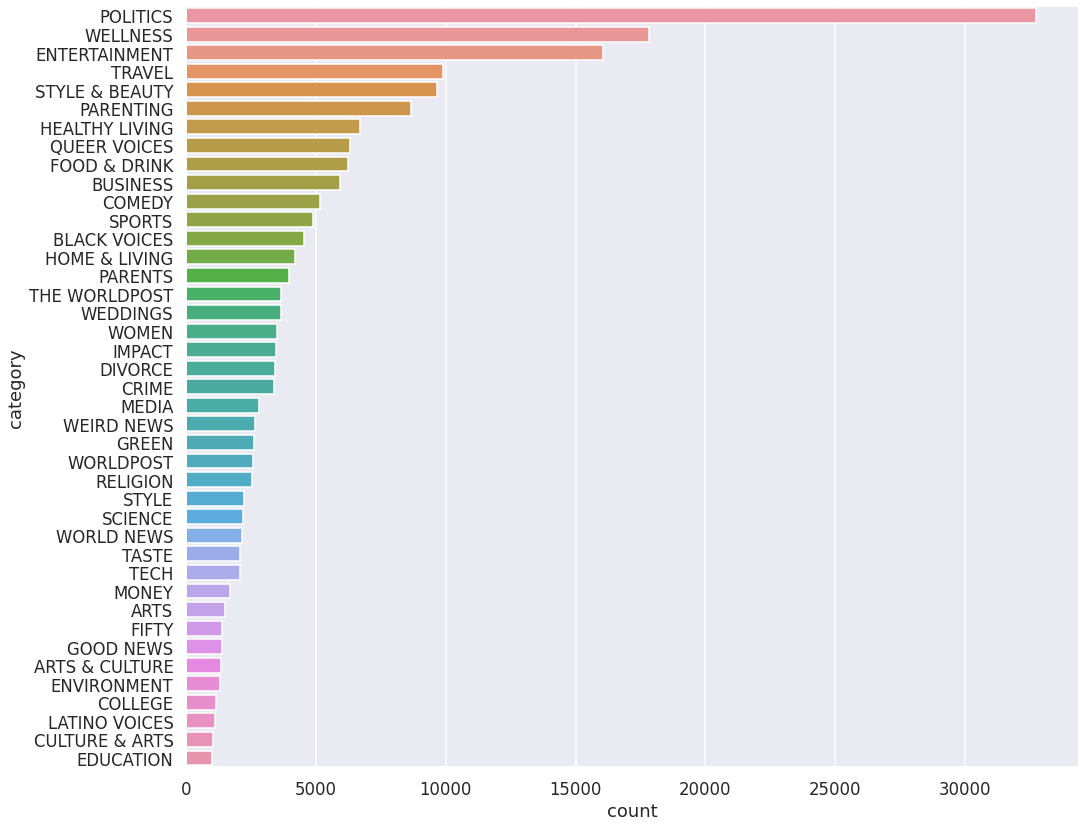

In [6]:
fig, ax = plt.subplots(figsize=(16, 14))
sns.countplot(data=df, y='category', order=df.category.value_counts().index, ax=ax)
#plt.xticks(rotation=90)
plt.show()

### Seleccionamos las noticias a utilizar

In [7]:
#df = df[df.category=='POLITICS']
categories = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'BUSINESS', 'CRIME', 'SPORTS']
df = df[df.category.isin(categories)]
df = df.groupby(by='category').sample(1000)
df.sample(5)

,category,headline,authors,link,short_description,date
146342,BUSINESS,Nearly All Employed Americans Do Work-Related ...,"CNBC, CNBC",https://www.huffingtonpost.com/entry/working-d...,"More From CNBC: -- Legal pot creates jobs, big...",2013-09-02
147061,WELLNESS,Does Your Job Pose Hazards to Your Sleep?,"Dr. Michael J. Breus, Contributor\nClinical Ps...",https://www.huffingtonpost.com/entry/importanc...,Given the scope of the role that work plays in...,2013-08-25
54039,ENTERTAINMENT,Kim K Takes Heat For Posting Racy Pic After De...,Julia Brucculieri,https://www.huffingtonpost.com/entry/kim-karda...,"""Your husband and son are black. Are you conce...",2016-07-07
114144,CRIME,Ohio Woman Sent To Prison For School Outburst,,https://www.huffingtonpost.com/entry/jessica-s...,,2014-08-21
184425,WELLNESS,Not All Happiness Is the Same,"Art Markman, Ph.D., Contributor\nExecutive Edi...",https://www.huffingtonpost.com/entry/happiness...,An interesting aspect of these kinds of happin...,2012-07-23


In [8]:
df['text'] = df['headline'] + ' ' + df['short_description']

## Descartamos las columnas que no usaremos
df = df.drop(columns=['headline', 'authors', 'link', 'short_description', 'date'])

### Aplicamos el pipeline de `spaCy`

In [9]:
df['doc'] = df['text'].progress_apply(nlp)

  0%|          | 0/7000 [00:00<?, ?it/s]

In [10]:
doc = df['doc'].values[10]
text = doc.text
tokens = [token.text for token in doc]
lemmas = [token.lemma_ for token in doc]
pos_tag = [(token, token.pos_) for token in doc]

In [11]:
print('texto: ', doc)
print('tokens:', tokens)
print('lemas: ', lemmas)

texto:  U.S. Electric Sector Expected To Hit Lowest CO2 Emissions In 20 Years This will be the first time the industry emits fewer than 2 billion metric tons since 1995.
tokens: ['U.S.', 'Electric', 'Sector', 'Expected', 'To', 'Hit', 'Lowest', 'CO2', 'Emissions', 'In', '20', 'Years', 'This', 'will', 'be', 'the', 'first', 'time', 'the', 'industry', 'emits', 'fewer', 'than', '2', 'billion', 'metric', 'tons', 'since', '1995', '.']
lemas:  ['U.S.', 'Electric', 'Sector', 'expect', 'to', 'hit', 'low', 'CO2', 'Emissions', 'in', '20', 'year', 'this', 'will', 'be', 'the', 'first', 'time', 'the', 'industry', 'emit', 'few', 'than', '2', 'billion', 'metric', 'ton', 'since', '1995', '.']


In [12]:
pprint(pos_tag)

[(U.S., 'PROPN'),
 (Electric, 'PROPN'),
 (Sector, 'PROPN'),
 (Expected, 'VERB'),
 (To, 'PART'),
 (Hit, 'VERB'),
 (Lowest, 'ADJ'),
 (CO2, 'PROPN'),
 (Emissions, 'PROPN'),
 (In, 'ADP'),
 (20, 'NUM'),
 (Years, 'NOUN'),
 (This, 'DET'),
 (will, 'AUX'),
 (be, 'VERB'),
 (the, 'DET'),
 (first, 'ADJ'),
 (time, 'NOUN'),
 (the, 'DET'),
 (industry, 'NOUN'),
 (emits, 'VERB'),
 (fewer, 'ADJ'),
 (than, 'SCONJ'),
 (2, 'NUM'),
 (billion, 'NUM'),
 (metric, 'ADJ'),
 (tons, 'NOUN'),
 (since, 'SCONJ'),
 (1995, 'NUM'),
 (., 'PUNCT')]


In [13]:
def get_lemmas(doc):
    return [token.lemma_ for token in doc]

def get_tokens(doc):
    return [token.text for token in doc]

def is_uninformative(token):
    return (
        token.lemma_ == '-PRON-'
        or token.is_stop 
        or token.is_punct 
        or token.is_space
    )

def get_relevant_tokens(doc):
    return [
        token.text for token in doc 
        if not is_uninformative(token)
    ]

def get_relevant_lemmas(doc):
    return [
        token.lemma_ for token in doc 
        if not is_uninformative(token)
    ]

df['tokens'] = df.doc.apply(get_tokens)
df['lemmas'] = df.doc.apply(get_lemmas)
df['clean_tokens'] = df.doc.apply(get_relevant_tokens)
df['clean_lemmas'] = df.doc.apply(get_relevant_lemmas)
df.head()

,category,text,doc,tokens,lemmas,clean_tokens,clean_lemmas
91055,BUSINESS,"Go East, Young Man -- Why Hong Kong is the Sil...","(Go, East, ,, Young, Man, --, Why, Hong, Kong,...","[Go, East, ,, Young, Man, --, Why, Hong, Kong,...","[go, East, ,, Young, Man, --, why, Hong, Kong,...","[East, Young, Man, Hong, Kong, Silicon, Valley...","[East, Young, Man, Hong, Kong, Silicon, Valley..."
104833,BUSINESS,Time Matters It's almost impossible to stop yo...,"(Time, Matters, It, 's, almost, impossible, to...","[Time, Matters, It, 's, almost, impossible, to...","[time, matter, it, be, almost, impossible, to,...","[Time, Matters, impossible, stop, procrastinat...","[time, matter, impossible, stop, procrastinate..."
60857,BUSINESS,Here Are The Manufacturers Bringing The Most J...,"(Here, Are, The, Manufacturers, Bringing, The,...","[Here, Are, The, Manufacturers, Bringing, The,...","[here, be, the, Manufacturers, bring, the, Mos...","[Manufacturers, Bringing, Jobs, America, Makin...","[Manufacturers, bring, Jobs, America, Making, ..."
100875,BUSINESS,5 Tips for a Mindful 2015 The start of another...,"(5, Tips, for, a, Mindful, 2015, The, start, o...","[5, Tips, for, a, Mindful, 2015, The, start, o...","[5, tip, for, a, mindful, 2015, the, start, of...","[5, Tips, Mindful, 2015, start, year, great, t...","[5, tip, mindful, 2015, start, year, great, ti..."
108840,BUSINESS,Marketing Evolution Is Failing In The C-Suite ...,"(Marketing, Evolution, Is, Failing, In, The, C...","[Marketing, Evolution, Is, Failing, In, The, C...","[marketing, Evolution, be, fail, in, the, C, -...","[Marketing, Evolution, Failing, C, Suite, Mark...","[marketing, Evolution, fail, C, Suite, Marketi..."


## Detección de tópicos

In [14]:
def create_dictionary(list_of_terms):
    dictionary = Dictionary(clean_text)
    print('Full     dictionary length:', len(dictionary))
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    print('Filtered dictionary length:', len(dictionary))
    return dictionary

Construimos nuestro diccionario y nuestro corpus

In [15]:
clean_text = df.clean_lemmas
print('Number of words:', len(clean_text))
print('-' * 30)

## Creamos el diccionario
dictionary = create_dictionary(clean_text)

## Para cada texto, creamos la bolsa de palabras
corpus = [dictionary.doc2bow(doc) for doc in clean_text]

Number of words: 7000
------------------------------
Full     dictionary length: 21649
Filtered dictionary length: 4213


Normalizamos utilizando el métodod TF-IDF

In [16]:
tfidf = TfidfModel(corpus)  # fit model
normalized_corpus = tfidf[corpus]  # apply model to the first corpus document

### Entrenamos el modelo

In [17]:
lsamodel = LsiModel(tfidf[corpus], id2word=dictionary, num_topics=17)

In [18]:
lsamodel.print_topics(num_words=10)

[(0,
  '0.239*"Trump" + 0.182*"say" + 0.168*"year" + 0.139*"time" + 0.138*"New" + 0.132*"Donald" + 0.131*"like" + 0.115*"want" + 0.109*"life" + 0.109*"thing"'),
 (1,
  '0.723*"Trump" + 0.459*"Donald" + -0.107*"year" + 0.103*"say" + 0.087*"Obama" + -0.084*"life" + -0.084*"find" + 0.080*"President" + -0.075*"time" + 0.074*"Clinton"'),
 (2,
  '-0.333*"Police" + -0.197*"say" + -0.191*"year" + -0.190*"kill" + -0.161*"man" + 0.156*"good" + 0.154*"like" + -0.151*"shoot" + -0.142*"Man" + 0.134*"way"'),
 (3,
  '0.787*"New" + 0.330*"York" + 0.168*"Year" + 0.125*"City" + -0.112*"say" + -0.090*"thing" + -0.089*"life" + 0.065*"new" + 0.064*"Jersey" + -0.064*"want"'),
 (4,
  '-0.356*"year" + 0.310*"like" + -0.238*"$" + -0.215*"America" + -0.203*"U.S." + 0.147*"Police" + -0.145*"10" + 0.137*"life" + -0.136*"Wall" + -0.135*"St."'),
 (5,
  '-0.410*"say" + 0.298*"year" + 0.200*"travel" + -0.200*"U.S." + 0.193*"Trump" + -0.175*"like" + -0.148*"$" + 0.148*"Police" + -0.142*"watch" + 0.136*"Donald"'),
 (6,

### Nube de palabras

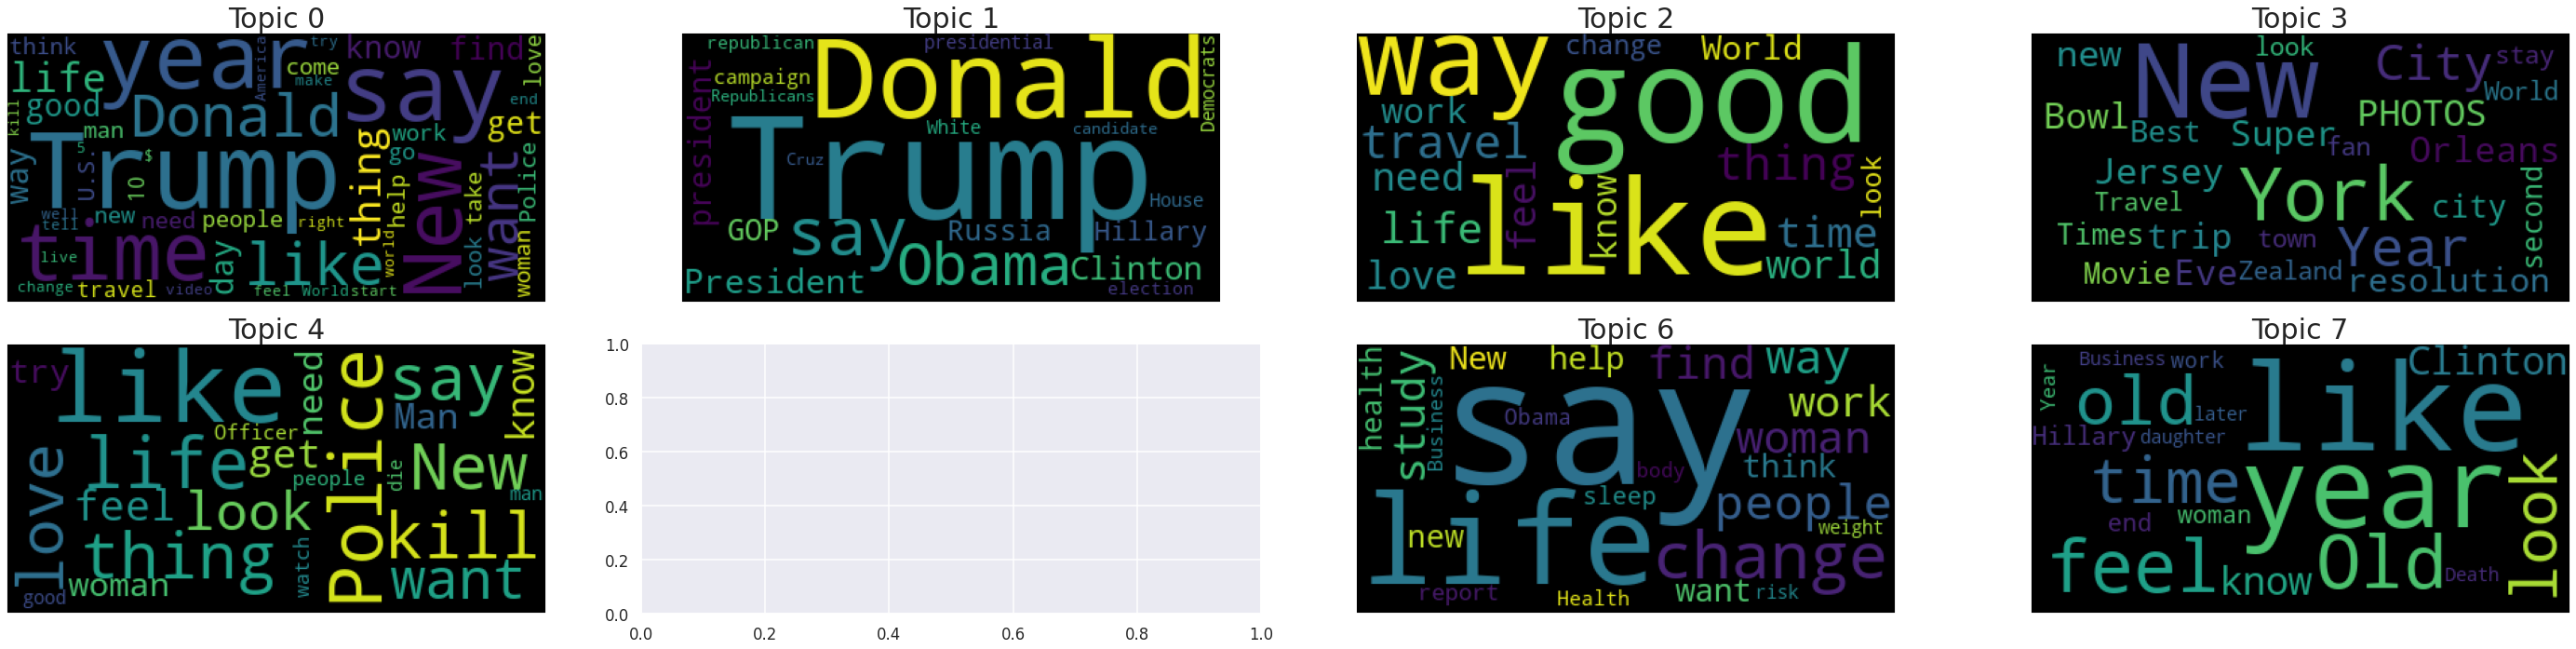

In [19]:
num_words = 50
ncols = 4 
nrows = 2
fig, axes = plt.subplots(figsize=(10*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for i, ax in enumerate(axes):
    topic = lsamodel.show_topic(i, num_words)
    try:
        wordcloud = WordCloud().fit_words(dict(topic))
    except:
        continue
    ax.set_title(f'Topic {i}', fontsize=30)
    ax.imshow(wordcloud)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

### Visualización interactiva

## Estimación del número óptimo de tópicos

La métrica que utilizamos para determinar qué tan buena es la división de los tópicos es la coherencia.

In [20]:
coherence_values = {}

In [21]:
def compute_coherence(model, texts, dictionary, coherence='c_v'):
    coherence_model = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence=coherence
    )
    return coherence_model.get_coherence()

for num_topics in tqdm(range(10, 20, 1)):
    if num_topics in coherence_values:
        continue
        
    lsamodel = LsiModel(tfidf[corpus], id2word=dictionary, num_topics=num_topics)

    # Calculamos la coherencia de los tópicos
    coherence = compute_coherence(lsamodel, clean_text, dictionary, coherence='c_v')
    coherence_values[num_topics] = coherence

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
data = sorted([(n, c) for n, c in coherence_values.items()], key=lambda x: x[0])
stats = pd.DataFrame(data, columns=['num_topics', 'coherence'])

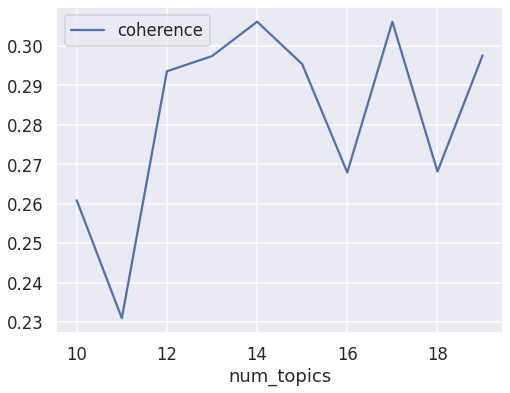

In [23]:
stats.plot(x='num_topics', y='coherence', figsize=(8,6));

## Bonus Track: visualización interactiva 

-----------------------


Otro modelo frecuentemente empleado para detección de tópicos es Latent Dirichlet Allocation (LDA). Entrenaremos este modelo y utilizaremos la librería `pyLDAvis` para realizar una visualización interactiva de los tópicos encontrados.

Entrenamos el modelo

In [24]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [25]:
lda_model = LdaModel(
  corpus=corpus,
  id2word=dictionary,
  num_topics=20,
  random_state=100,
  update_every=1,
  chunksize=100,
  passes=10,
  alpha='auto',
  per_word_topics=True
)

Visualizamos

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook(sort=True)
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)